In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

from notebooks.nlp_basics import lemmatizer

from notebooks.books_reviews import vader_sentiment

In [4]:
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = "#00bfbf"

In [5]:
data = pd.read_csv("../data_files/fake_news_data.csv")

In [6]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

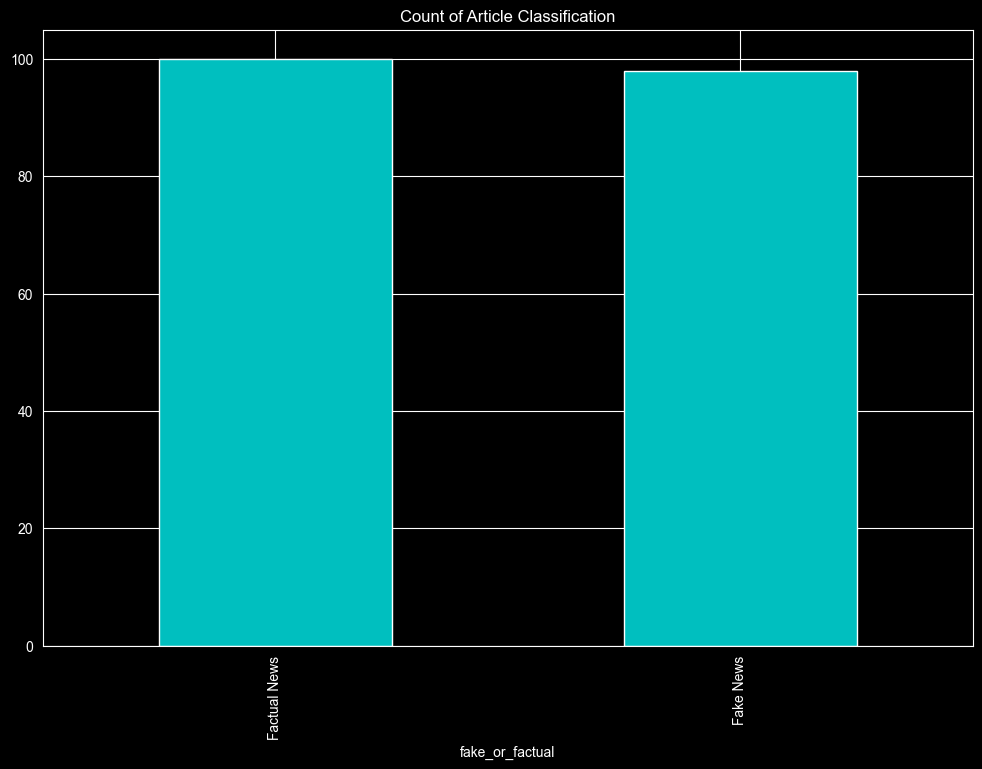

In [8]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title("Count of Article Classification")

POS TAGGING

In [9]:
nlp = spacy.load('en_core_web_sm')

In [10]:
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

In [11]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [12]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [13]:
fake_tagsdf = []
columns = ['token', 'ner_tag', 'pos_tag']

In [14]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)


In [15]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [16]:
fact_tagsdf = []
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

In [17]:
fact_tagsdf = pd.concat(fact_tagsdf)

In [18]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [20]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [21]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


NAMED ENTITIES

In [26]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [27]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

[Text(0.5, 1.0, 'Top 10 Entities Fake news')]

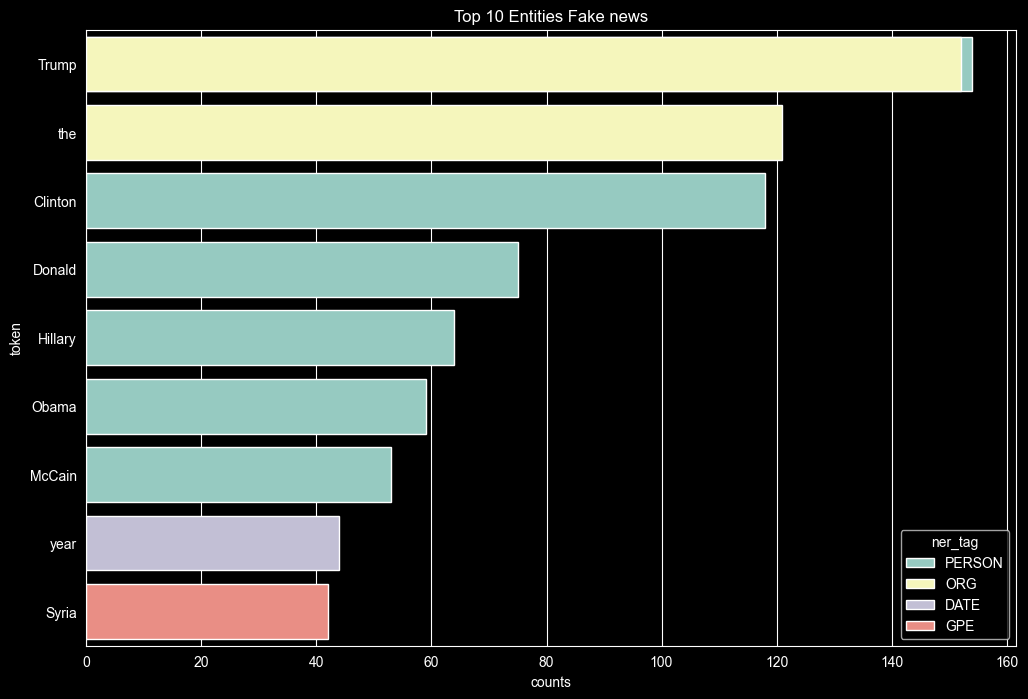

In [28]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fake[:10],
    orient='h',
    dodge=False,
).set(title = 'Top 10 Entities Fake news')

[Text(0.5, 1.0, 'Top 10 Entities Fact news')]

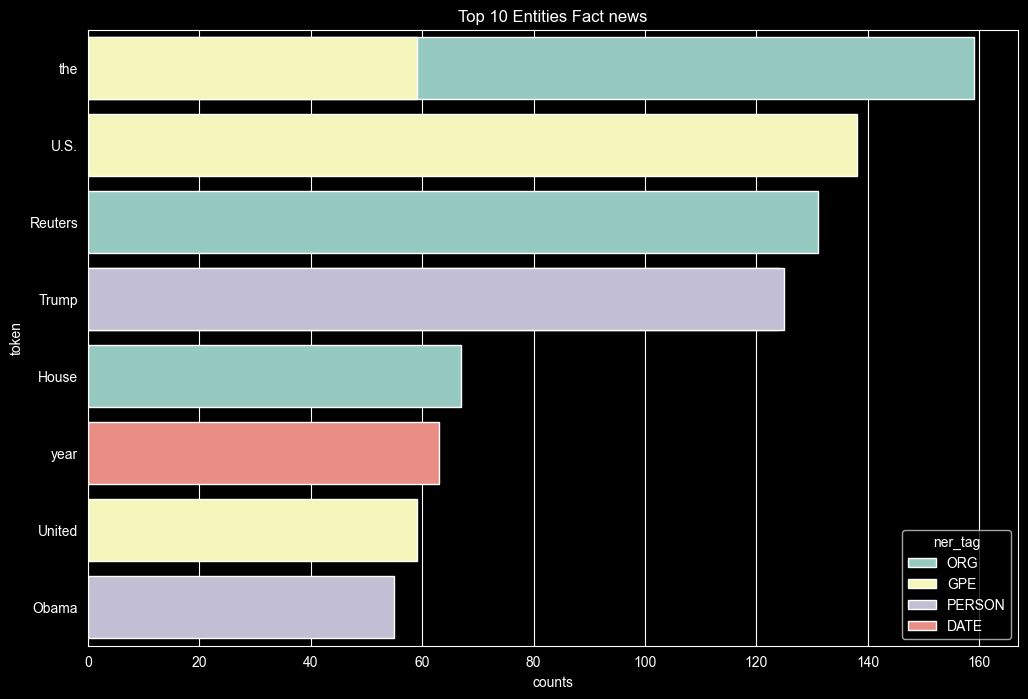

In [29]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fact[:10],
    orient='h',
    dodge=False,
).set(title = 'Top 10 Entities Fact news')

TEXT PRE-PROCESSING

In [30]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [41]:
data['cleaned_text'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1)

In [42]:
data.head()

,title,text,date,fake_or_factual,cleaned_text
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [46]:
data['cleaned_text_lower'] = data['cleaned_text'].str.lower()

In [47]:
data.head()

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...


In [48]:
data['cleaned_text_lower_no_punct'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['cleaned_text_lower']), axis=1)

In [49]:
data.head()

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower,cleaned_text_lower_no_punct
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,...",women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...


In [50]:
en_stopwards = stopwords.words('english')

In [51]:
data['no_stopwords'] = data['cleaned_text_lower_no_punct'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwards]))

In [52]:
data.head(5)

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower,cleaned_text_lower_no_punct,no_stopwords
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,...",women make up over 50 percent of this country ...,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...,us defense secretary jim mattis said on monday...,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...


In [53]:
data['tokens'] = data.apply(lambda x: word_tokenize(x['no_stopwords']), axis=1)

In [55]:
lemmatizer = WordNetLemmatizer()
data['lemmatized'] = data['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens] )

In [56]:
data.head(5)

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower,cleaned_text_lower_no_punct,no_stopwords,tokens,lemmatized
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,...",women make up over 50 percent of this country ...,women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...,us defense secretary jim mattis said on monday...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,..."


In [57]:
tokens_clean = sum(data['lemmatized'], [])

In [60]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1))).value_counts().reset_index(name='counts')
print(unigrams[:10])

           index  counts
0        (said,)     580
1       (trump,)     580
2           (u,)     277
3       (state,)     275
4   (president,)     259
5       (would,)     226
6         (one,)     160
7     (clinton,)     141
8        (year,)     139
9  (republican,)     137


[Text(0.5, 1.0, 'Unigrams')]

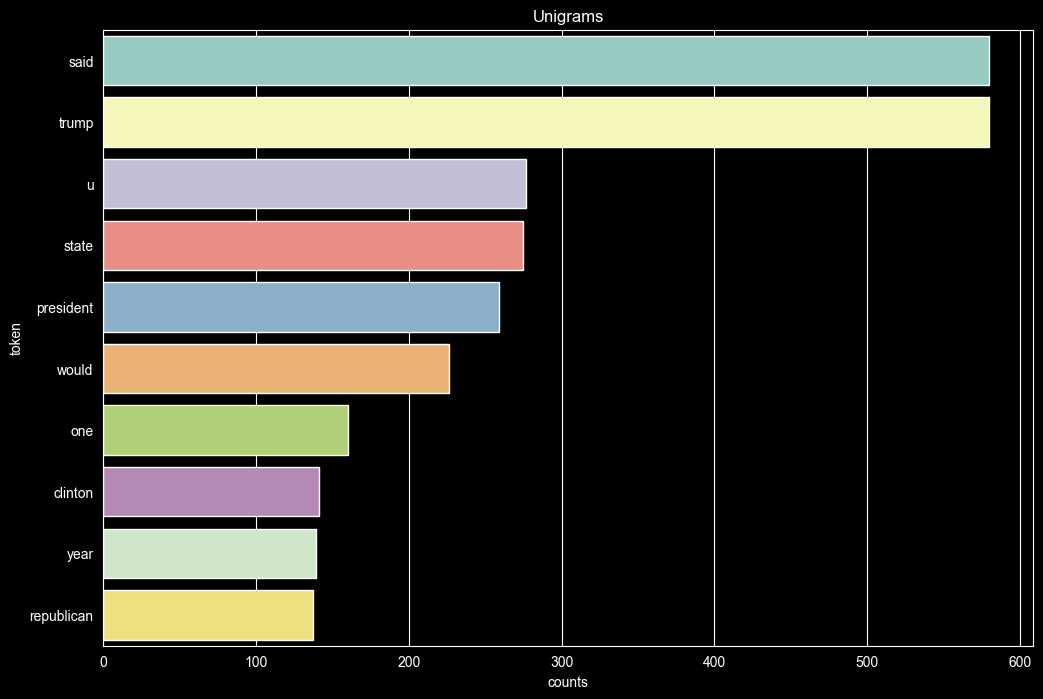

In [63]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])
sns.barplot(
    x = 'counts',
    y = 'token',
    data = unigrams[:10],
    orient='h',
    hue = 'token',legend=False,
).set(title = 'Unigrams')

In [64]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2))).value_counts().reset_index(name='counts')
print(bigrams[:10])

                     index  counts
0          (donald, trump)     113
1          (united, state)      84
2           (white, house)      74
3      (president, donald)      47
4       (hillary, clinton)      39
5              (new, york)      33
6         (supreme, court)      30
7             (image, via)      29
8         (official, said)      26
9  (trump, administration)      26


[Text(0.5, 1.0, 'Bigrams')]

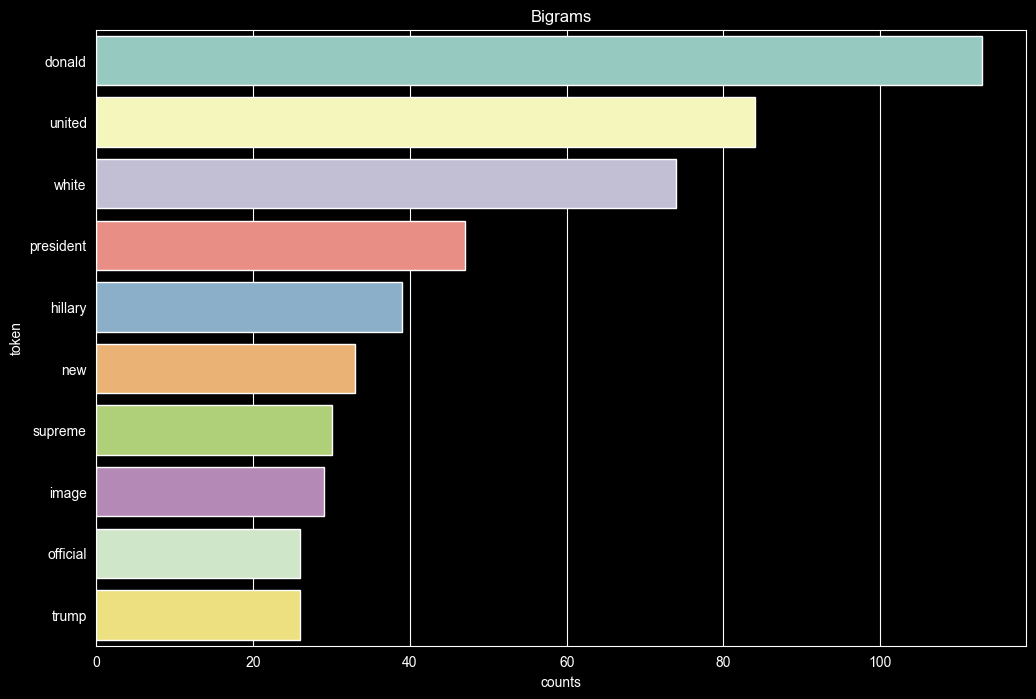

In [65]:
bigrams['token'] = bigrams['index'].apply(lambda x: x[0])
sns.barplot(
    x = 'counts',
    y = 'token',
    data = bigrams[:10],
    orient='h',
    hue = 'token',legend=False,
).set(title = 'Bigrams')

SENTIMENT ANALYSIS

In [66]:
vader_sentiment = SentimentIntensityAnalyzer()

In [67]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [68]:
data.head()

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower,cleaned_text_lower_no_punct,no_stopwords,tokens,lemmatized,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,...",women make up over 50 percent of this country ...,women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...,us defense secretary jim mattis said on monday...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,...",0.8590


In [69]:
bins = [-1,-0.1,0.1,1]
names = ['negative','neutral','positive']

In [70]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [71]:
data.head()

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower,cleaned_text_lower_no_punct,no_stopwords,tokens,lemmatized,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,...",women make up over 50 percent of this country ...,women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...,us defense secretary jim mattis said on monday...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

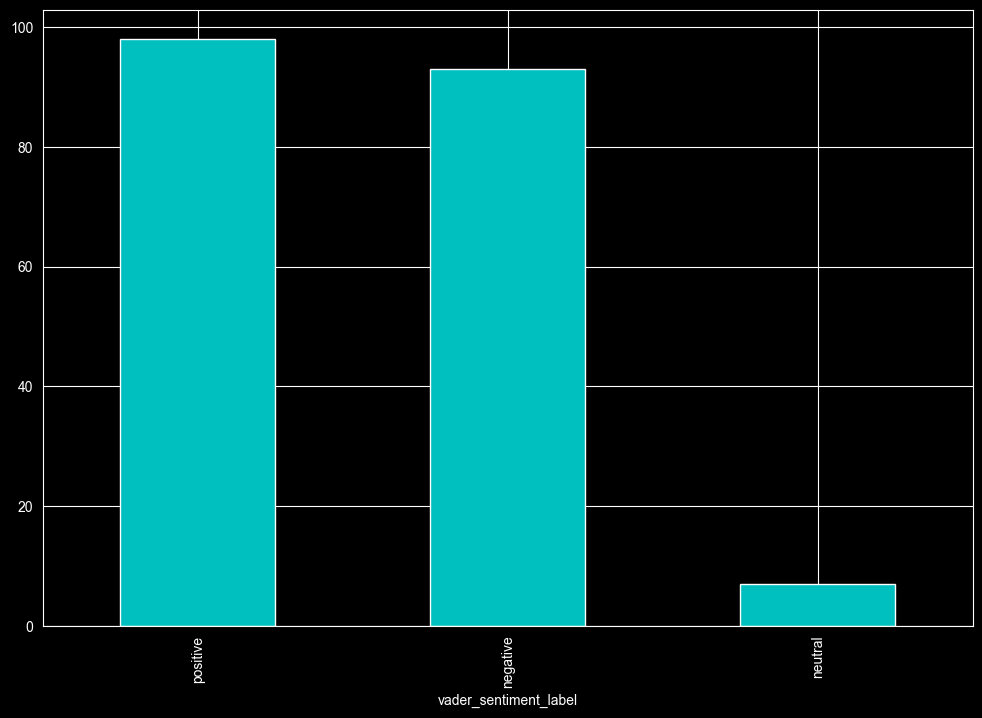

In [72]:
data['vader_sentiment_label'].value_counts().plot(kind='bar', color=default_plot_color)

/var/folders/g9/j9g8cjvn4bvcvf60hmxtzzg80000gq/T/ipykernel_63647/4178162877.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment Split')]

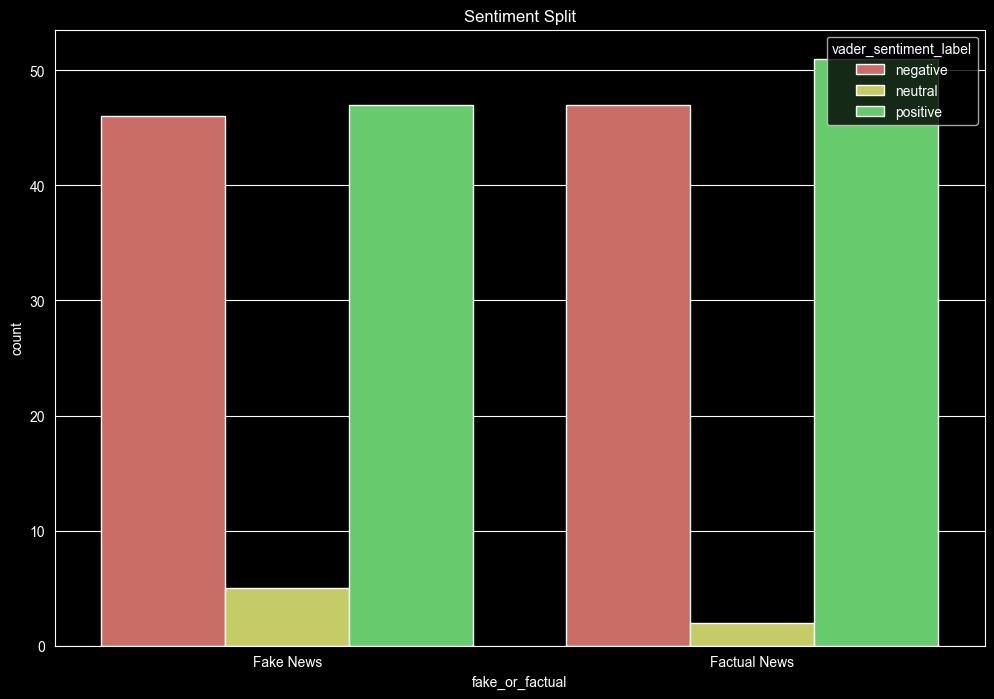

In [73]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette=sns.color_palette("hls"),
    data=data,
).set(title = 'Sentiment Split')

TOPIC MODELLING

In [80]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]["lemmatized"].reset_index(drop=True)

In [82]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [83]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [84]:
coherence_values = []
model_list = []
min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics + 1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word=dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

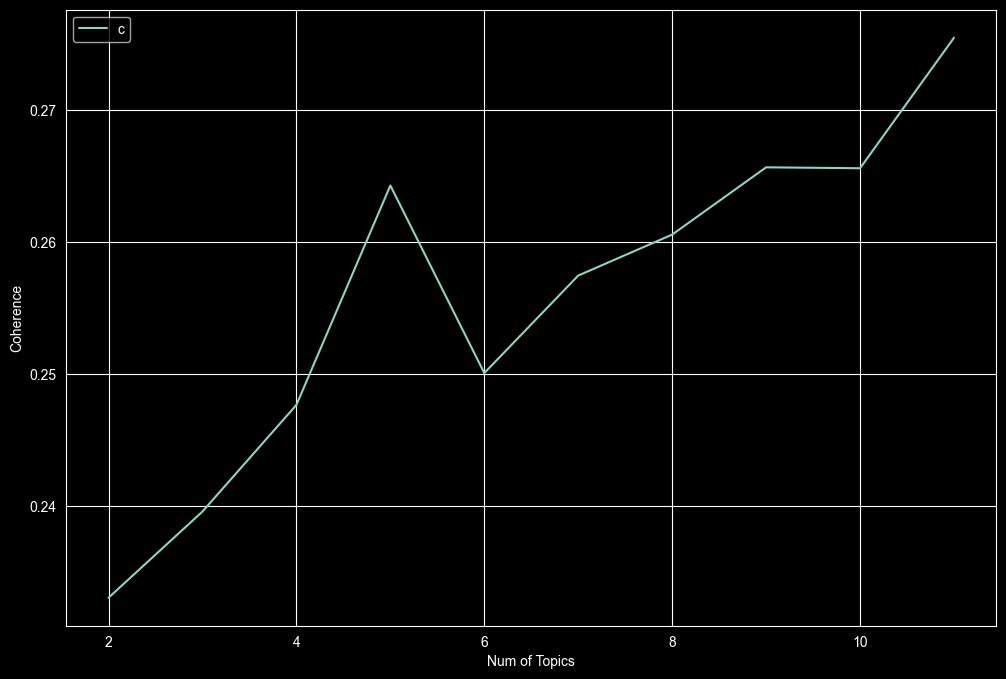

In [87]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel("Num of Topics")
plt.ylabel("Coherence")
plt.legend(("coherence_value"), loc="best")
plt.show()

In [88]:
num_topic_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, num_topics=num_topic_lda, id2word=dictionary_fake)

In [89]:
lda_model.print_topics(num_topics=num_topic_lda, num_words=10)

[(0,
  '0.014*"trump" + 0.007*"said" + 0.006*"would" + 0.005*"president" + 0.004*"clinton" + 0.004*"state" + 0.004*"time" + 0.003*"u" + 0.003*"one" + 0.003*"woman"'),
 (1,
  '0.010*"trump" + 0.004*"said" + 0.004*"clinton" + 0.004*"president" + 0.004*"time" + 0.003*"donald" + 0.003*"would" + 0.003*"one" + 0.003*"state" + 0.003*"two"'),
 (2,
  '0.008*"trump" + 0.006*"clinton" + 0.005*"president" + 0.004*"said" + 0.004*"state" + 0.004*"obama" + 0.003*"email" + 0.003*"go" + 0.003*"official" + 0.003*"year"'),
 (3,
  '0.012*"trump" + 0.005*"president" + 0.005*"said" + 0.004*"state" + 0.004*"one" + 0.004*"u" + 0.003*"obama" + 0.003*"would" + 0.003*"know" + 0.003*"time"'),
 (4,
  '0.008*"trump" + 0.005*"republican" + 0.004*"said" + 0.004*"state" + 0.004*"u" + 0.004*"clinton" + 0.003*"woman" + 0.003*"president" + 0.003*"people" + 0.003*"party"'),
 (5,
  '0.007*"trump" + 0.005*"president" + 0.004*"u" + 0.004*"one" + 0.004*"would" + 0.004*"woman" + 0.003*"said" + 0.003*"people" + 0.003*"year" + 0

In [90]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [91]:
def get_coherence_scores(corpus, dictionary, min, max):
    coherence_values = []
    model_list = []
    for num_i in range(min, max + 1):
        model = LsiModel(corpus=corpus, num_topics=num_i, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=fake_news_text, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    plt.plot(range(min, max + 1), coherence_values)
    plt.xlabel("Num of Topics")
    plt.ylabel("Coherence")
    plt.legend(("coherence_value"), loc="best")
    plt.show()

In [92]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

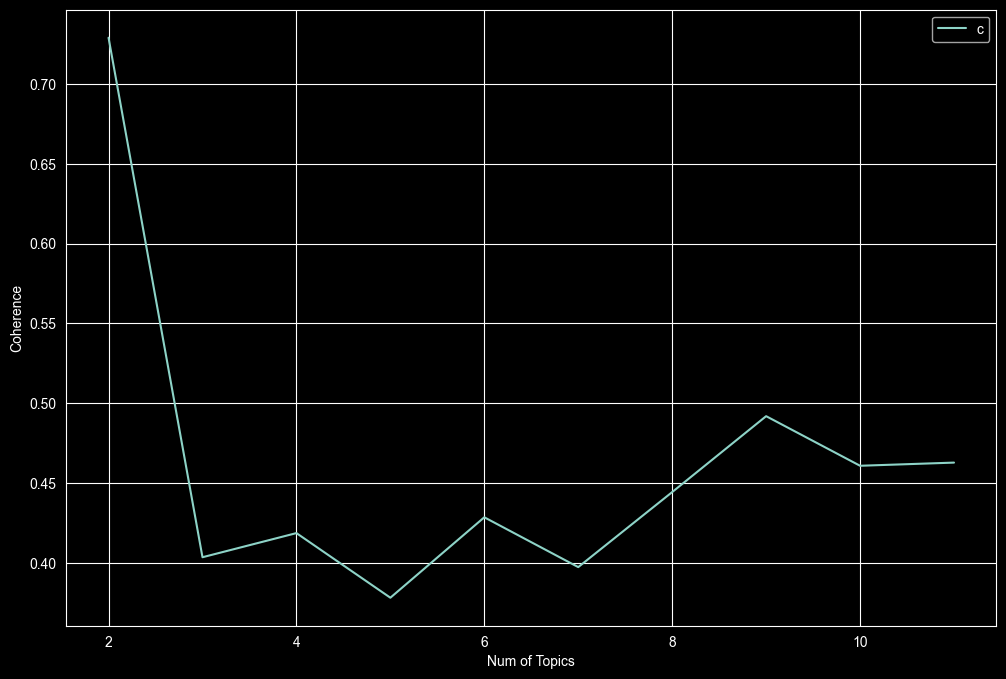

In [93]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, 2, 11)

In [95]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)

In [96]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '-0.623*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.186*"school" + -0.176*"student" + 0.141*"hillary" + -0.121*"county" + -0.121*"flynn" + 0.110*"sander" + 0.098*"debate" + 0.097*"woman" + 0.091*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.142*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '0.276*"student" + 0.160*"conference" + 0.160*"school" + 0.137*"trump" + -0.125*"mcc

Creating Custom Classification Model

In [97]:
data.head()

,title,text,date,fake_or_factual,cleaned_text,cleaned_text_lower,cleaned_text_lower_no_punct,no_stopwords,tokens,lemmatized,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...,there are two small problems with your analogy...,there are two small problems with your analogy...,two small problems analogy susan jesus muslim ...,"[two, small, problems, analogy, susan, jesus, ...","[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried in trump s bonkers interview with new y...,buried trump bonkers interview new york times ...,"[buried, trump, bonkers, interview, new, york,...","[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,...","women make up over 50 percent of this country,...",women make up over 50 percent of this country ...,women make 50 percent country grossly underrep...,"[women, make, 50, percent, country, grossly, u...","[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...,u.s. defense secretary jim mattis said on mond...,us defense secretary jim mattis said on monday...,us defense secretary jim mattis said monday ru...,"[us, defense, secretary, jim, mattis, said, mo...","[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland s political parties are rapid...,northern ireland political parties rapidly run...,"[northern, ireland, political, parties, rapidl...","[northern, ireland, political, party, rapidly,...",0.8590,positive


In [98]:
X = [','.join(map(str, l)) for l in data['lemmatized']]

In [99]:
y = data['fake_or_factual']

In [100]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)

In [102]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [103]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

In [104]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [105]:
y_pred = lr.predict(X_test)

In [107]:
accuracy_score(y_pred, y_test)

0.8833333333333333

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Factual News       0.86      0.94      0.90        34
   Fake News       0.91      0.81      0.86        26

    accuracy                           0.88        60
   macro avg       0.89      0.87      0.88        60
weighted avg       0.89      0.88      0.88        60



In [109]:
svm = SGDClassifier().fit(X_train, y_train)

In [110]:
y_pred_svm = svm.predict(X_test)

In [111]:
accuracy_score(y_pred_svm, y_test)

0.9166666666666666

In [112]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.91      0.94      0.93        34
   Fake News       0.92      0.88      0.90        26

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.92        60

